# Memory Information

In [50]:
import psutil
def get_size(bytes, suffix="B"):
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor
print("="*40, "Memory Information", "="*40)
svmem = psutil.virtual_memory()
print(f"Total: {get_size(svmem.total)}") ; print(f"Available: {get_size(svmem.available)}")
print(f"Used: {get_size(svmem.used)}") ; print(f"Percentage: {svmem.percent}%")

======================================== Memory Information ========================================
Total: 25.51GB
Available: 22.46GB
Used: 3.29GB
Percentage: 12.0%


# GPU Information

In [51]:
! nvidia-smi

Tue Aug  4 11:11:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    32W / 250W |   5091MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [4]:
import time;
start = time.time()
!unzip -q 'gdrive/My Drive/Pull-0-Depth/MonoDepth_Inp_Dataset_192.zip' -d 'Data/'
print (time.time() - start)

233.10646629333496


In [5]:
import time;

start = time.time()
!unzip -q 'gdrive/My Drive/Pull-0-Depth/MonoDepth_GT_Dataset_192.zip' -d 'Data/Dataset/depth_'
print (time.time() - start)

72.08990716934204


In [6]:
import time;

start = time.time()
!unzip -q 'gdrive/My Drive/Pull-0-Depth/bg_192.zip' -d 'Data/Dataset/bg_'
print (time.time() - start)

12.057763576507568


In [1]:
import os

list_m = os.listdir('Data/Dataset/mask_/mask') # dir is your directory path
list_f = os.listdir('Data/Dataset/fg_bg_/fg_bg') # dir is your directory path
list_d = os.listdir('Data/Dataset/depth_/depth') # dir is your directory path
list_b_temp = os.listdir('Data/Dataset/bg_/bg_192') # dir is your directory path

list_f.sort()
list_m.sort()
list_d.sort()
list_b_temp.sort()

list_b = []
for bg in list_b_temp:
    list_b += [bg]*4000

print('No. of fg_bg Images: ', len(list_f))
print('No. of mask Images: ', len(list_m))
print('No. of depth Images: ', len(list_d))
print('No. of backround Images: ', len(list_b))

No. of fg_bg Images:  400000
No. of mask Images:  400000
No. of depth Images:  400000
No. of backround Images:  400000


In [2]:
f = open("file_name.txt", "a")
g = open("bg_name.txt", "a")
for line in list_f:
    f.write(f"{line} 0\n")
    g.write(f"{line[:8]}.jpg 0\n")
f.close()
g.close()

In [3]:
print('Sample FG_BG Image: ',list_f[351275])
print('Sample BG Image: ',list_b[351275])
print('Sample MASK Image: ',list_m[351275])
print('Sample DEPTh Image: ',list_d[351275])

Sample FG_BG Image:  bg192_87_fg3275.jpg
Sample BG Image:  bg192_87.jpg
Sample MASK Image:  bg192_87_fg3275.jpg
Sample DEPTh Image:  bg192_87_fg3275.jpg


In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import time

In [5]:
#Creating Split of Data for Training and Testing of 70:30
import random

for _ in range(50):
    seed = random.random()
    def rand_num():
        return seed
    random.shuffle(list_f, rand_num)
    random.shuffle(list_b, rand_num)

#Testing if Randomizing worked
print(list_f[351275])
print(list_b[351275])

bg192_23_fg3609.jpg
bg192_23.jpg


In [38]:
train_data = list_f[0:12800]
test_data = list_f[102800:106000]
print(len(train_data), len(test_data))

12800 3200


In [7]:
class DepMaskDataset(Dataset):
    def __init__(self, file_list):
        
        self.to_tensor = transforms.ToTensor()
        self.fg_norm = transforms.Normalize(mean = [0.56414794921875, 0.5432481169700623, 0.5214933753013611],
                                            std = [0.208669513463974, 0.213966503739357, 0.2230370044708252])
        self.bg_norm = transforms.Normalize(mean = [0.5810659527778625, 0.5633341670036316, 0.5403051972389221],
                                            std= [0.18558748066425323, 0.19134603440761566, 0.20390349626541138])
        self.mask_norm = transforms.Normalize(mean = 0.09639497846364975,
                                              std = 0.2823259234428406)
        self.depth_norm = transforms.Normalize(mean = 0.40525129437446594,
                                               std = 0.24363896250724792)
        self.file_name_list = file_list
        self.fgbg = 'Data/Dataset/fg_bg_/fg_bg/'
        self.bg = 'Data/Dataset/bg_/bg_192/'
        self.mask = 'Data/Dataset/mask_/mask/'
        self.depth = 'Data/Dataset/depth_/depth/'
        self.len = len(self.file_name_list)

        
    def __getitem__(self, index):
        # stuff

        fg = Image.open(self.fgbg+self.file_name_list[index]).convert('RGB')
        bg = Image.open(self.bg+self.file_name_list[index][0:8]+'.jpg').convert('RGB')
        mask = Image.open(self.mask+self.file_name_list[index]).convert('L')
        mask_arr = np.array(mask)
        mask_arr[mask_arr >= 150] = 255
        mask_arr[mask_arr < 150]  = 0
        mask = Image.fromarray(mask_arr).convert('L')
        depth = Image.open(self.depth+self.file_name_list[index]).convert('L')
        
        fg = self.to_tensor(fg)
        bg = self.to_tensor(bg)
        mask = self.to_tensor(mask)
        depth = self.to_tensor(depth)

        fg = self.fg_norm(fg)
        bg = self.bg_norm(bg)
        mask = self.mask_norm(mask)
        depth = self.depth_norm(depth)

        return {'fgbg': fg, 'bg': bg, 'mask':mask, 'depth': depth}

    def __len__(self):
        return self.len # of how many data(images) you have

In [41]:
train_dataset = DepMaskDataset(train_data)
test_dataset = DepMaskDataset(test_data)

In [42]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [10]:
data = next(iter(train_loader))
print(type(data))
print(len(data))

<class 'dict'>
4


In [11]:
print(len(train_loader))
print(len(test_loader))

400
100


In [12]:
print('Number of fg_bg Images in one batch: ', data['fgbg'].shape)
print('Number of bg Images in one batch: ', data['bg'].shape)
print('Number of mask Images in one batch: ', data['mask'].shape)
print('Number of depth Images in one batch: ', data['depth'].shape)

Number of fg_bg Images in one batch:  torch.Size([32, 3, 192, 192])
Number of bg Images in one batch:  torch.Size([32, 3, 192, 192])
Number of mask Images in one batch:  torch.Size([32, 1, 192, 192])
Number of depth Images in one batch:  torch.Size([32, 1, 192, 192])


In [13]:
from tqdm import tqdm
load_start = time.time()
pbar = tqdm(train_loader)
for batch_idx, data in enumerate(pbar):
        fgbg, bg = data['fgbg'].to('cuda'), data['bg'].to('cuda')
        mask, depth = data['mask'].to('cuda'), data['depth'].to('cuda')
        model_inp = torch.cat((fgbg, bg), dim=1)
load_end = time.time()
print('\n Total Loading Time ',load_end-load_start)

100%|██████████| 400/400 [00:32<00:00, 12.33it/s]


 Total Loading Time  32.44303560256958


In [14]:
from UNet import UNet
from loss import BCEDiceLoss, RMSELoss, rmse, miou
import torch.optim as optim
from tqdm import tqdm
import gc

In [15]:
model = UNet(6).to('cuda')
optimizer = optim.Adam(model.parameters())

In [16]:
from torchsummary import summary
summary(model, (6,192,192))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 192, 192]           3,456
       BatchNorm2d-2         [-1, 64, 192, 192]             128
              ReLU-3         [-1, 64, 192, 192]               0
            Conv2d-4         [-1, 64, 192, 192]          36,864
       BatchNorm2d-5         [-1, 64, 192, 192]             128
              ReLU-6         [-1, 64, 192, 192]               0
        DoubleConv-7  [[-1, 64, 192, 192], [-1, 64, 192, 192]]               0
         MaxPool2d-8           [-1, 64, 96, 96]               0
            Conv2d-9          [-1, 128, 96, 96]          73,728
      BatchNorm2d-10          [-1, 128, 96, 96]             256
             ReLU-11          [-1, 128, 96, 96]               0
           Conv2d-12          [-1, 128, 96, 96]         147,456
      BatchNorm2d-13          [-1, 128, 96, 96]             256
             ReLU-14    

In [17]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

In [27]:
def train(train_loader, model, optimizer):

    gc.collect()
    torch.cuda.empty_cache()

    model.train()
    pbar = tqdm(train_loader)
    seg_crit = BCEDiceLoss()
    dep_crit = RMSELoss()
    load_time, pred_time, loss_time, back_time, misc_time = 0,0,0,0,0
    start = time.time()
    total_segloss, total_deploss, total_ = 0,0,0
    total_iou, total_rmse = 0,0

    for batch_idx, data in enumerate(pbar):
        load_start = time.time()
        fgbg, bg = data['fgbg'].to('cuda'), data['bg'].to('cuda')
        mask, depth = data['mask'].to('cuda'), data['depth'].to('cuda')

        model_inp = torch.cat((fgbg, bg), dim=1)
        load_end = time.time()
        load_time += load_end - load_start

        pred_start = time.time()
        optimizer.zero_grad()
        y_pred = model(model_inp)
        pred_end = time.time()
        pred_time += pred_end - pred_start

        loss_start = time.time()
        seg_loss = seg_crit(y_pred[:, :1, :, :], mask)
        dep_loss = dep_crit(y_pred[:, 1:, :, :], depth)
        total_loss = seg_loss + dep_loss
        with torch.no_grad():
            total_segloss += seg_loss
            total_deploss += dep_loss
            total_iou += miou(y_pred[:, :1, :, :], mask)
            total_rmse += rmse(y_pred[:, 1:, :, :], depth)
            total_ += total_loss
        loss_end = time.time()
        loss_time += loss_end - loss_start

        back_start = time.time()
        total_loss.backward()
        optimizer.step()
        back_end = time.time()
        back_time += back_end - back_start
        

    print('\nLoad Time: ', load_time)
    print('Prediciton Time: ', pred_time)
    print('Loss Time: ', loss_time)
    print('Backprop Time: ', back_time)
    print('Total Time for One Batch: ', time.time() - start)
    print('********************* LOSSES ****************************')
    print('Segmentation Loss: ', (total_segloss/len(pbar)).item())
    print('Depth Loss: ', (total_deploss/len(pbar)).item())
    print('Total Loss: ', (total_/len(pbar)).item())
    print('mean IOU: ', (total_iou/len(pbar)).item())
    print('mean RMSE: ', (total_rmse/len(pbar)).item())
    print('********************* ****** ****************************')

    del fgbg, bg, mask, depth
    del model_inp, y_pred
    
    gc.collect()
    torch.cuda.empty_cache()

In [28]:
def test(test_loader, model):

    gc.collect()
    torch.cuda.empty_cache()

    model.eval()
    pbar = tqdm(test_loader)
    seg_crit = BCEDiceLoss()
    dep_crit = RMSELoss()
    load_time, pred_time, loss_time= 0,0,0
    start = time.time()
    total_segloss, total_deploss, total_ = 0,0,0
    total_iou, total_rmse = 0,0

    with torch.no_grad():
        for batch_idx, data in enumerate(pbar):
            load_start = time.time()
            fgbg, bg = data['fgbg'].to('cuda'), data['bg'].to('cuda')
            mask, depth = data['mask'].to('cuda'), data['depth'].to('cuda')

            model_inp = torch.cat((fgbg, bg), dim=1)
            load_end = time.time()
            load_time += load_end - load_start

            pred_start = time.time()
            optimizer.zero_grad()
            y_pred = model(model_inp)
            pred_end = time.time()
            pred_time += pred_end - pred_start

            loss_start = time.time()
            seg_loss = seg_crit(y_pred[:, :1, :, :], mask)
            dep_loss = dep_crit(y_pred[:, 1:, :, :], depth)
            total_segloss += seg_loss
            total_deploss += dep_loss
            total_ += seg_loss + dep_loss
            total_iou += miou(y_pred[:, :1, :, :], mask)
            total_rmse += rmse(y_pred[:, 1:, :, :], depth)
            loss_end = time.time()
            loss_time += loss_end - loss_start

        

    print('\nLoad Time: ', load_time)
    print('Prediciton Time: ', pred_time)
    print('Loss Time: ', loss_time)
    print('Total Time for One Batch: ', time.time() - start)
    print('********************* LOSSES ****************************')
    print('Segmentation Loss: ', (total_segloss/len(pbar)).item())
    print('Depth Loss: ', (total_deploss/len(pbar)).item())
    print('Total Loss: ', (total_/len(pbar)).item())
    print('mean IOU: ', (total_iou/len(pbar)).item())
    print('mean RMSE: ', (total_rmse/len(pbar)).item())
    print('********************* ****** ****************************')

    return mask, depth, y_pred[:, :1, :, :], y_pred[:, 1:, :, :]
    

In [26]:
start_process = time.time()
for i in range(1,15):
    epoch_time = time.time()
    train(train_loader, model, optimizer)
    print(f'********* EPOCH {i+1} TIME: {time.time()-epoch_time} seconds')
    print('******************************************************************************************************************')
print(torch.cuda.memory_allocated())
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated())
mask_gt, depth_gt, mask_ot, depth_ot = test(test_loader, model)
print('Total Time: ', time.time() - start_process)

100%|██████████| 400/400 [03:20<00:00,  1.99it/s]



Load Time:  188.67521834373474
Prediciton Time:  2.822603225708008
Loss Time:  0.5411462783813477
Backprop Time:  4.762819051742554
Total Time for One Batch:  200.88339471817017
********************* LOSSES ****************************
Segmentation Loss:  1.1029281616210938
Depth Loss:  0.12782032787799835
Total Loss:  1.7420287132263184
mean IOU:  0.2716015875339508
mean RMSE:  0.12782032787799835
********************* ****** ****************************


  0%|          | 0/400 [00:00<?, ?it/s]

********* EPOCH 2 TIME: 201.70888209342957 seconds
******************************************************************************************************************


100%|██████████| 400/400 [03:20<00:00,  1.99it/s]



Load Time:  188.35859155654907
Prediciton Time:  2.929989814758301
Loss Time:  0.5570740699768066
Backprop Time:  4.870265245437622
Total Time for One Batch:  200.91666889190674
********************* LOSSES ****************************
Segmentation Loss:  1.101245641708374
Depth Loss:  0.10979416966438293
Total Loss:  1.650216817855835
mean IOU:  0.2718007266521454
mean RMSE:  0.10979416966438293
********************* ****** ****************************


  0%|          | 0/400 [00:00<?, ?it/s]

********* EPOCH 3 TIME: 201.67899751663208 seconds
******************************************************************************************************************


100%|██████████| 400/400 [03:20<00:00,  1.99it/s]



Load Time:  188.132976770401
Prediciton Time:  2.950075626373291
Loss Time:  0.5604026317596436
Backprop Time:  4.994873046875
Total Time for One Batch:  200.90436244010925
********************* LOSSES ****************************
Segmentation Loss:  1.1006450653076172
Depth Loss:  0.10176098346710205
Total Loss:  1.6094506978988647
mean IOU:  0.27186107635498047
mean RMSE:  0.10176098346710205
********************* ****** ****************************


  0%|          | 0/400 [00:00<?, ?it/s]

********* EPOCH 4 TIME: 201.65753388404846 seconds
******************************************************************************************************************


100%|██████████| 400/400 [03:20<00:00,  1.99it/s]



Load Time:  188.05630493164062
Prediciton Time:  2.9718754291534424
Loss Time:  0.5691609382629395
Backprop Time:  5.038147211074829
Total Time for One Batch:  200.92179107666016
********************* LOSSES ****************************
Segmentation Loss:  1.099974513053894
Depth Loss:  0.09744749963283539
Total Loss:  1.5872124433517456
mean IOU:  0.2719310224056244
mean RMSE:  0.09744749963283539
********************* ****** ****************************


  0%|          | 0/400 [00:00<?, ?it/s]

********* EPOCH 5 TIME: 201.69489979743958 seconds
******************************************************************************************************************


100%|██████████| 400/400 [03:20<00:00,  1.99it/s]



Load Time:  188.04355645179749
Prediciton Time:  2.9895684719085693
Loss Time:  0.5676653385162354
Backprop Time:  5.057231664657593
Total Time for One Batch:  200.94576621055603
********************* LOSSES ****************************
Segmentation Loss:  1.099715232849121
Depth Loss:  0.09362819790840149
Total Loss:  1.5678565502166748
mean IOU:  0.27195248007774353
mean RMSE:  0.09362819790840149
********************* ****** ****************************
********* EPOCH 6 TIME: 201.70234394073486 seconds

  0%|          | 0/400 [00:00<?, ?it/s]


******************************************************************************************************************


100%|██████████| 400/400 [03:20<00:00,  1.99it/s]



Load Time:  188.2376573085785
Prediciton Time:  2.915163516998291
Loss Time:  0.5589213371276855
Backprop Time:  4.940877914428711
Total Time for One Batch:  200.92267322540283
********************* LOSSES ****************************
Segmentation Loss:  1.0993425846099854
Depth Loss:  0.09161953628063202
Total Loss:  1.5574390888214111
mean IOU:  0.2719983160495758
mean RMSE:  0.09161953628063202
********************* ****** ****************************
********* EPOCH 7 TIME: 201.67921900749207 seconds
******************************************************************************************************************


100%|██████████| 400/400 [03:20<00:00,  1.99it/s]



Load Time:  188.29336309432983
Prediciton Time:  2.9276888370513916
Loss Time:  0.5587770938873291
Backprop Time:  4.893030166625977
Total Time for One Batch:  200.9275107383728
********************* LOSSES ****************************
Segmentation Loss:  1.0994404554367065
Depth Loss:  0.08919430524110794
Total Loss:  1.5454113483428955
mean IOU:  0.2719811499118805
mean RMSE:  0.08919430524110794
********************* ****** ****************************


  0%|          | 0/400 [00:00<?, ?it/s]

********* EPOCH 8 TIME: 201.67530250549316 seconds
******************************************************************************************************************


100%|██████████| 400/400 [03:20<00:00,  1.99it/s]



Load Time:  188.27317309379578
Prediciton Time:  2.9502763748168945
Loss Time:  0.5509569644927979
Backprop Time:  4.88530969619751
Total Time for One Batch:  200.94685316085815
********************* LOSSES ****************************
Segmentation Loss:  1.0989117622375488
Depth Loss:  0.08668661117553711
Total Loss:  1.532344937324524
mean IOU:  0.27204638719558716
mean RMSE:  0.08668661117553711
********************* ****** ****************************
********* EPOCH 9 TIME: 201.6936182975769 seconds
******************************************************************************************************************


100%|██████████| 400/400 [03:20<00:00,  1.99it/s]



Load Time:  188.3225600719452
Prediciton Time:  2.9045753479003906
Loss Time:  0.5604803562164307
Backprop Time:  4.895559549331665
Total Time for One Batch:  200.90842413902283
********************* LOSSES ****************************
Segmentation Loss:  1.0990664958953857
Depth Loss:  0.0852937176823616
Total Loss:  1.5255351066589355
mean IOU:  0.27202388644218445
mean RMSE:  0.0852937176823616
********************* ****** ****************************
********* EPOCH 10 TIME: 201.66214966773987 seconds
******************************************************************************************************************


100%|██████████| 400/400 [03:20<00:00,  1.99it/s]



Load Time:  188.2869095802307
Prediciton Time:  2.950784683227539
Loss Time:  0.5613503456115723
Backprop Time:  4.896433115005493
Total Time for One Batch:  200.95307993888855
********************* LOSSES ****************************
Segmentation Loss:  1.0988689661026
Depth Loss:  0.0835961326956749
Total Loss:  1.5168492794036865
mean IOU:  0.27204644680023193
mean RMSE:  0.0835961326956749
********************* ****** ****************************


  0%|          | 0/400 [00:00<?, ?it/s]

********* EPOCH 11 TIME: 201.7142083644867 seconds
******************************************************************************************************************


100%|██████████| 400/400 [03:20<00:00,  1.99it/s]



Load Time:  188.20257019996643
Prediciton Time:  2.960824728012085
Loss Time:  0.5600569248199463
Backprop Time:  4.909669637680054
Total Time for One Batch:  200.96735334396362
********************* LOSSES ****************************
Segmentation Loss:  1.0992801189422607
Depth Loss:  0.08173912763595581
Total Loss:  1.5079752206802368
mean IOU:  0.2719845473766327
mean RMSE:  0.08173912763595581
********************* ****** ****************************


  0%|          | 0/400 [00:00<?, ?it/s]

********* EPOCH 12 TIME: 201.72569489479065 seconds
******************************************************************************************************************


100%|██████████| 400/400 [03:20<00:00,  1.99it/s]



Load Time:  188.31027841567993
Prediciton Time:  2.958051919937134
Loss Time:  0.563906192779541
Backprop Time:  4.8961098194122314
Total Time for One Batch:  200.9066526889801
********************* LOSSES ****************************
Segmentation Loss:  1.0988538265228271
Depth Loss:  0.08027179539203644
Total Loss:  1.5002132654190063
mean IOU:  0.272045761346817
mean RMSE:  0.08027179539203644
********************* ****** ****************************
********* EPOCH 13 TIME: 201.6657955646515 seconds
******************************************************************************************************************


100%|██████████| 400/400 [03:20<00:00,  1.99it/s]



Load Time:  188.29656410217285
Prediciton Time:  2.9440343379974365
Loss Time:  0.5533933639526367
Backprop Time:  4.904317378997803
Total Time for One Batch:  200.91998529434204
********************* LOSSES ****************************
Segmentation Loss:  1.0986701250076294
Depth Loss:  0.07887016236782074
Total Loss:  1.493021845817566
mean IOU:  0.27207034826278687
mean RMSE:  0.07887016236782074
********************* ****** ****************************


  0%|          | 0/400 [00:00<?, ?it/s]

********* EPOCH 14 TIME: 201.66942858695984 seconds
******************************************************************************************************************


100%|██████████| 400/400 [03:20<00:00,  1.99it/s]



Load Time:  188.29657530784607
Prediciton Time:  2.9339334964752197
Loss Time:  0.5593113899230957
Backprop Time:  4.932789087295532
Total Time for One Batch:  200.9379482269287
********************* LOSSES ****************************
Segmentation Loss:  1.0984381437301636
Depth Loss:  0.07684338092803955
Total Loss:  1.4826542139053345
mean IOU:  0.2720998525619507
mean RMSE:  0.07684338092803955
********************* ****** ****************************


  0%|          | 0/100 [00:00<?, ?it/s]

********* EPOCH 15 TIME: 201.6884846687317 seconds
******************************************************************************************************************
588729344
588729344


100%|██████████| 100/100 [00:16<00:00,  5.90it/s]


Load Time:  14.728970527648926
Prediciton Time:  0.6433484554290771
Loss Time:  0.12499690055847168
Total Time for One Batch:  16.94770622253418
********************* LOSSES ****************************
Segmentation Loss:  1.0975524187088013
Depth Loss:  0.08631053566932678
Total Loss:  1.1838629245758057
mean IOU:  0.27171507477760315
mean RMSE:  0.08631053566932678
********************* ****** ****************************
Total Time:  2840.762004137039


In [46]:
mask_gt, depth_gt, mask_ot, depth_ot = test(test_loader, model)

100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


Load Time:  14.823938608169556
Prediciton Time:  0.5934529304504395
Loss Time:  0.11877989768981934
Total Time for One Batch:  16.90640425682068
********************* LOSSES ****************************
Segmentation Loss:  1.0993460416793823
Depth Loss:  0.08630654215812683
Total Loss:  1.185652732849121
mean IOU:  0.2711428105831146
mean RMSE:  0.08630654215812683
********************* ****** ****************************


In [53]:
# mask_out = (mask_ot[1].cpu().numpy().transpose(1,2,0)*255).astype(np.uint8)[:,:,0]
# depth_out = (depth_ot[1].cpu().numpy().transpose(1,2,0)*255).astype(np.uint8)[:,:,0]
# mask_gt = (mask_gt[1].cpu().numpy().transpose(1,2,0)*255).astype(np.uint8)[:,:,0]
# depth_gt = (depth_gt[1].cpu().numpy().transpose(1,2,0)*255).astype(np.uint8)[:,:,0]

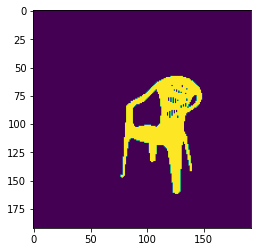

In [63]:
# img = unnorm_mask(mask_ot[28])
img[img >= 150] = 255
img[img < 150]  = 0
plt.imshow((img.cpu().numpy().transpose(1,2,0)).astype(np.uint8)[:,:,0])

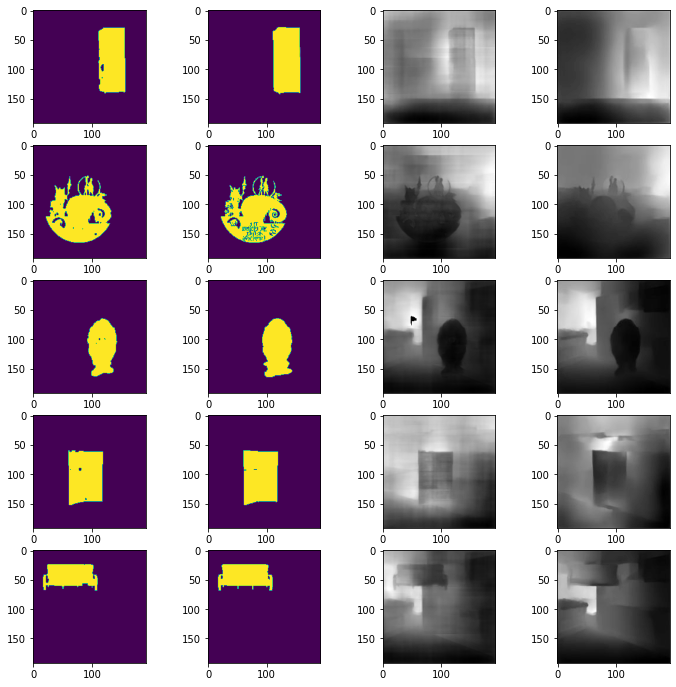

In [65]:
unnorm_mask = UnNormalize(mean= [0.09639497846364975*255], std= [0.2823259234428406*255])
unnorm_depth = UnNormalize(mean= [0.40525129437446594*255], std= [0.24363896250724792*255])

plt.figure(figsize=(12,12))
for i in range(1,20,4):
    plt.subplot(5,4,i)
    img = mask_ot[i+5]
    unnorm_mask(img)
    img[img >= 150] = 255
    img[img < 150]  = 0
    img = (img.cpu().numpy().transpose(1,2,0)).astype(np.uint8)[:,:,0]
    plt.imshow(img)
    plt.subplot(5,4,i+1)
    img = mask_gt[i+5]
    unnorm_mask(img)
    img = (img.cpu().numpy().transpose(1,2,0)).astype(np.uint8)[:,:,0]
    plt.imshow(img)
    plt.subplot(5,4,i+2)
    img = depth_ot[i+5]
    unnorm_depth(img)
    img = (img.cpu().numpy().transpose(1,2,0)).astype(np.uint8)[:,:,0]
    plt.imshow(img, cmap='binary_r')
    plt.subplot(5,4,i+3)
    img = depth_gt[i+5]
    unnorm_depth(img)
    img = (img.cpu().numpy().transpose(1,2,0)).astype(np.uint8)[:,:,0]
    plt.imshow(img, cmap='binary_r')